<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer

from catboost import Pool, CatBoostRegressor, cv
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor



from itertools import product

import warnings
warnings.filterwarnings("ignore")

RND = 12345

In [2]:
try:
    data_taxi = pd.read_csv('taxi.csv') 
except:
    data_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data_taxi.info())
data_taxi.sort_index(inplace=True)
data_taxi.head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
print('Количество пропусков:')
display(data_taxi.isna().sum())

Количество пропусков:


num_orders    0
dtype: int64

Датасет содержит 2 столбца, 26496 строк-записей, пропусков нет. Данные предоставлены с 1 марта по 31 августа 2018 года.

## Анализ

Данные времени в датасете представлены с разницей в 10 минут, поскольку это слишком подробные данные, выполним ресемплирование с интервалом в 1 час, расположим в хронологическом порядке.

In [5]:
data_taxi.sort_index(inplace=True)
data_taxi = data_taxi.resample('1H').sum()

In [6]:
display(data_taxi.info())
data_taxi.head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Посмотрим распределение данных на графике

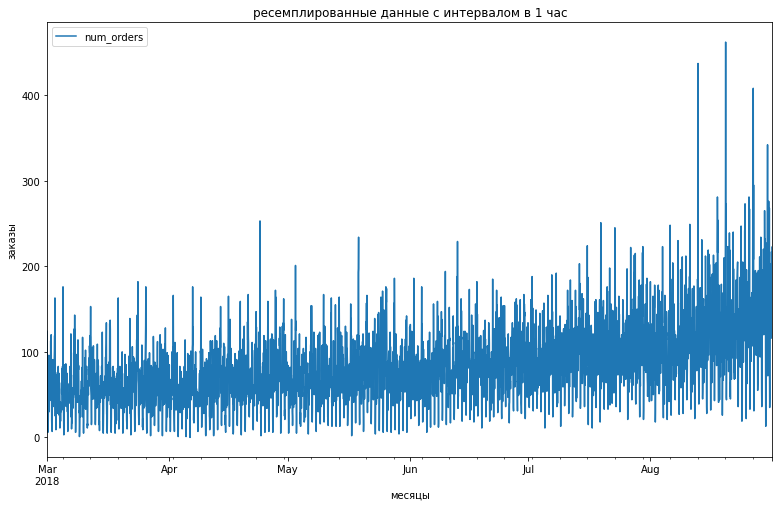

In [7]:
figsize = (13, 8)
data_taxi.plot(figsize=figsize)
plt.title('ресемплированные данные с интервалом в 1 час')
plt.xlabel('месяцы')
plt.ylabel('заказы')
plt.show()

Чтобы лучше изучить этот временной ряд, рассмотрим тренд, сезонную составляющую (сезонность), остаток декомпозиции (шум).

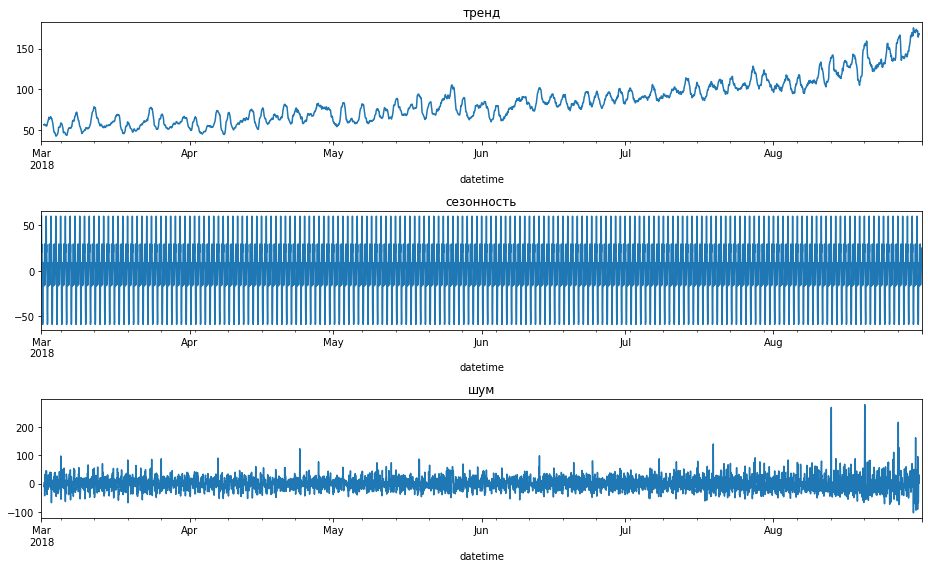

In [8]:
decomposed = seasonal_decompose(data_taxi)

plt.figure(figsize=(13, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('шум')
plt.tight_layout()

Не слишком показательно. Посмотрим-ка за более короткий срок, например, за первую неделю марта. 

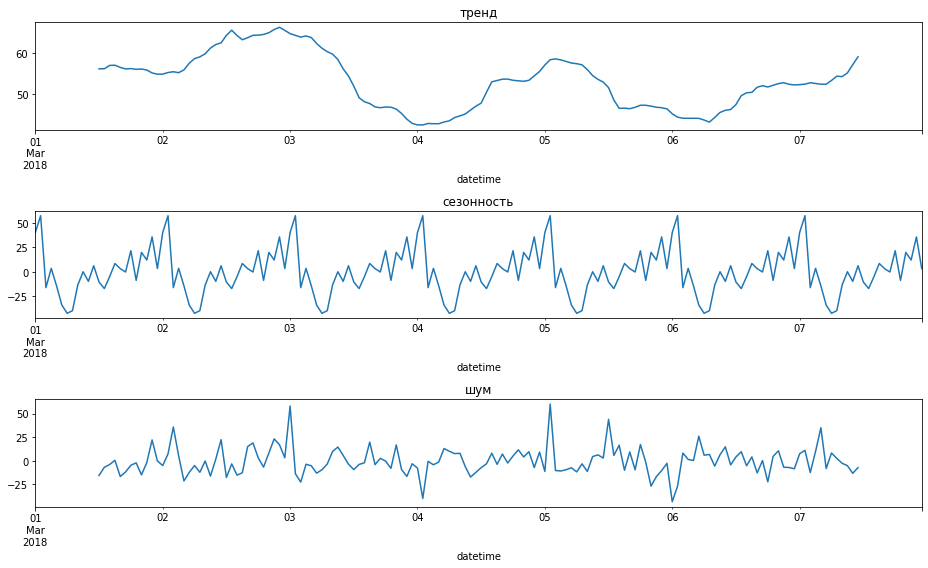

In [9]:
decomposed = seasonal_decompose(data_taxi['2018-03-01':'2018-03-07'])

plt.figure(figsize=(13, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('шум')
plt.tight_layout()

Теперь можем увидеть сезонность суточную, по которой видно, что ночью заказов меньше.

<AxesSubplot:xlabel='datetime'>

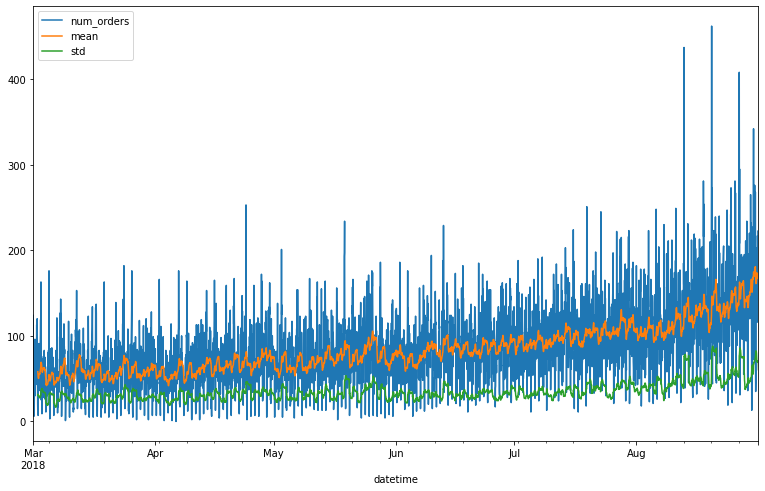

In [10]:
data_taxi_plot = data_taxi.copy()

data_taxi_plot['mean'] = data_taxi_plot['num_orders'].rolling(30).mean()
data_taxi_plot['std'] = data_taxi_plot['num_orders'].rolling(30).std()
data_taxi_plot.plot(figsize=(13, 8))


Найдём разности значений, чтобы сделать числовой ряд  стационарным.

<AxesSubplot:xlabel='datetime'>

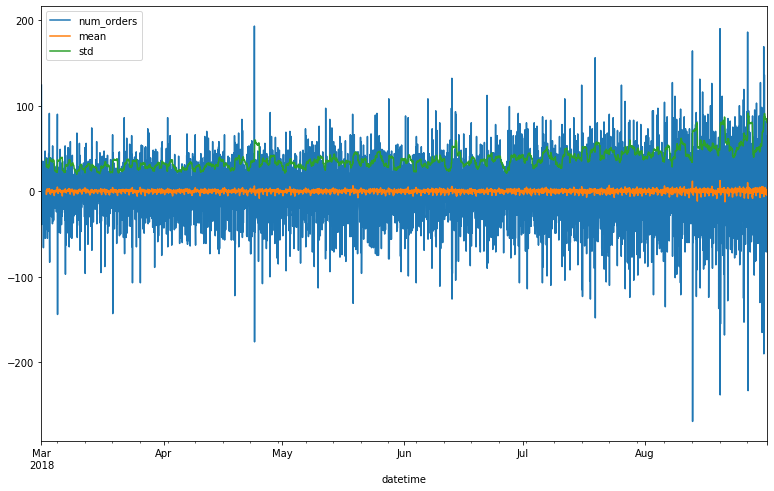

In [11]:
data_taxi_shift = data_taxi - data_taxi.shift(fill_value=0)
data_taxi_shift['mean'] = data_taxi_shift['num_orders'].rolling(30).mean()
data_taxi_shift['std'] = data_taxi_shift['num_orders'].rolling(30).std()
data_taxi_shift.plot(figsize=(13, 8))

Ряд стал более стационарным и значит готовым для прогнозов.

**Вывод по разделу анализа данных:**
<br>
Декомпозиция указала на общий тренд увеличения заказов.
Сезоность показала высокий спрос в вечернее время и спад в ночное, утреннее.

## Обучение

Создадим признаки для обучения моделей

In [12]:
data = data_taxi.copy()

In [13]:

def make_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
  
    return data

In [14]:
# выберем лаг 24 и скользящую равную 100
make_features(data_taxi, 24, 100)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,157.33
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,156.74
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,156.63


In [15]:
# удалим пропуски
data_taxi = data_taxi.dropna()

In [16]:
# разделими признаки и целевой признак

train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_train.shape, target_train.shape, features_test.shape, target_test.shape


((3884, 27), (3884,), (432, 27), (432,))

Обучим три модели: Линейную регрессию, Случайный лес и CatBoostRegressor.

**Линейная регрессия**

In [17]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predicted_lr = pd.Series(model_lr.predict(features_test))


In [18]:
# подберем параметры c помощью TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cb_parameters = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[RND],
                'verbose':[False]}]

In [19]:
lr_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

In [20]:
%%time
grid_lr = GridSearchCV(LinearRegression(), param_grid=lr_parameters, refit=False,
                       scoring='neg_mean_squared_error', cv=tscv)
grid_lr.fit(features_train, target_train)

best_parameters_lr = grid_lr.best_params_
lr_m = LinearRegression(**best_parameters_lr)
lr_m.fit(features_train, target_train)

mse_scores = cross_val_score(lr_m, features_train, target_train, scoring='neg_mean_squared_error', cv=tscv)
mean_mse = mse_scores.mean

test_pred_lr = lr_m.predict(features_test)

print('Лучшие гиперпараметры: ', best_parameters_lr)
print('Среднее MSE по кросс-валидации: ', mean_mse)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False}
Среднее MSE по кросс-валидации:  <built-in method mean of numpy.ndarray object at 0x7f1f4359f8d0>
CPU times: user 1.01 s, sys: 2.1 s, total: 3.12 s
Wall time: 3.09 s


**Случайный лес**

In [21]:
rf_params = {
        'n_estimators': range(5, 30, 5),
        'max_depth': range(1, 15, 2),
        'verbose': [0],
        'random_state': [RND] 
        }


In [22]:
%%time
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, refit=False,\
                       scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train)
    
rf_test_pred = rf_m.predict(features_test)

print('Лучшие гиперпараметры: ', rf_best_params)

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 20, 'random_state': 12345, 'verbose': 0}
CPU times: user 38.6 s, sys: 58.5 ms, total: 38.7 s
Wall time: 39.7 s


**CatBoostRegressor**

In [23]:
%%time

# создаем модель CatBoostRegressor
model_cb = CatBoostRegressor() 

cb_params = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[1234],
                'verbose':[False]}]

tscv = TimeSeriesSplit(n_splits=5)

cb_grid = GridSearchCV(model_cb, cb_params, scoring='neg_mean_squared_error', cv=tscv)
cb_grid.fit(features_train, target_train)

print("Лучшие параметры на обучающем наборе данных:")
print()
print(cb_grid.best_params_)
print()
print("Оценка комбинаций гиперпараметров на обучающей выборке:")
print()
means = cb_grid.cv_results_['mean_test_score']
stds = cb_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cb_grid.cv_results_['params']):
    print("%0.6f для %r"% ((mean*-1)** 0.5, params))
print()

cv_rmse_cb_ordinal = (max(means)*-1) ** 0.5

Лучшие параметры на обучающем наборе данных:

{'learning_rate': 0.1, 'random_state': 1234, 'verbose': False}

Оценка комбинаций гиперпараметров на обучающей выборке:

24.947026 для {'learning_rate': 0.1, 'random_state': 1234, 'verbose': False}
25.424824 для {'learning_rate': 0.2, 'random_state': 1234, 'verbose': False}
25.658823 для {'learning_rate': 0.3, 'random_state': 1234, 'verbose': False}

CPU times: user 1min 9s, sys: 1.06 s, total: 1min 10s
Wall time: 1min 33s


In [24]:
%%time

model_cb = CatBoostRegressor(learning_rate=0.1,
                              iterations = 500,
                              random_state=1234, 
                              verbose=False, 
                              ) 
tscv = TimeSeriesSplit(n_splits=5)
cv_rmse_cb_ordinal = (cross_val_score(model_cb,
                                      features_train,
                                      target_train,
                                      cv=tscv,
                                      scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Среднее значение RMSE при перекрестной проверке для CatBoostRegressor =', cv_rmse_cb_ordinal)

Среднее значение RMSE при перекрестной проверке для CatBoostRegressor = 24.874799603623753
CPU times: user 10.6 s, sys: 152 ms, total: 10.7 s
Wall time: 17.2 s


## Тестирование

**Тестирование модели линейной регрессии**

45.1744169554933


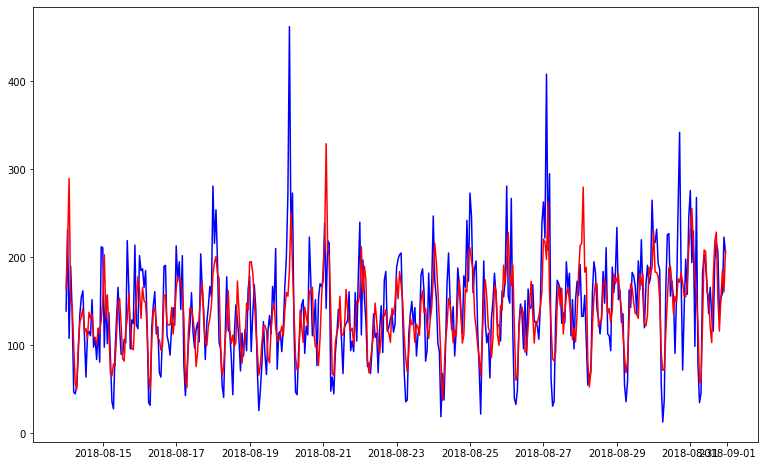

In [25]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
target_predict = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_lr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')
plt.show()

**Тестирование модели случайного леса**

45.1716491595106


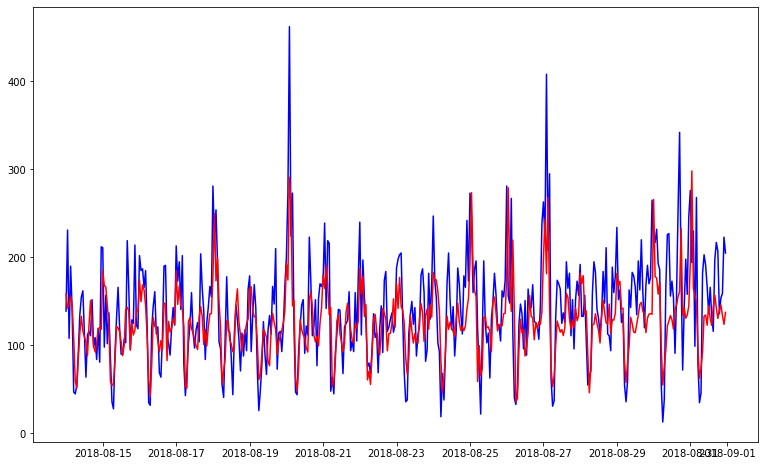

CPU times: user 1.09 s, sys: 20 ms, total: 1.11 s
Wall time: 1.11 s


In [29]:
%%time

model_rf = RandomForestRegressor(random_state=42,
                                     max_depth= 13,
                                     n_estimators = 20)

model_rf.fit(features_train, target_train)
model_rf_predictions = model_rf.predict(features_test)

rmse_forest = np.sqrt(mean_squared_error(target_test, model_rf_predictions))
print(rmse_forest)

plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, model_rf_predictions,'r-')
plt.show()

**Тестирование модели CatBoostRegressor**

43.862580569602045


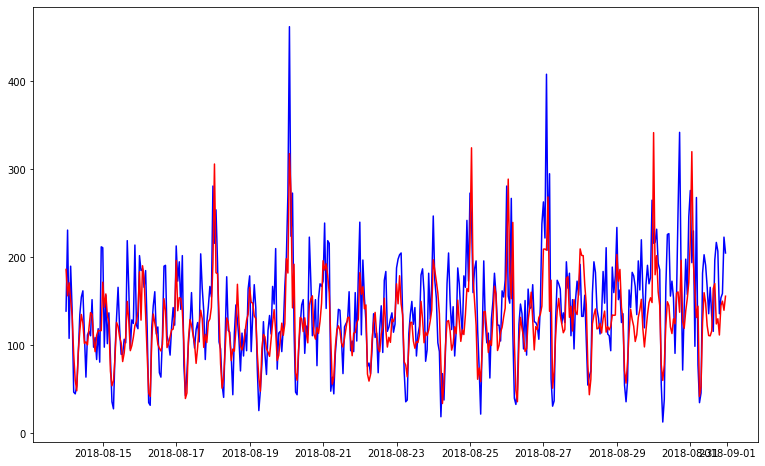

In [27]:
model_cb = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)
model_cb.fit(features_train, target_train)
model_cb_predict = model_cb.predict(features_test)
rmse_cb = mean_squared_error(target_test, model_cb_predict) ** 0.5
print(rmse_cb)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, model_cb_predict,'r-')
plt.show()

In [28]:
predictive_model_scores = pd.DataFrame(data=[('Linear Regression', rmse_lr),
                                             ('Random Forest', rmse_forest),
                                             ('CatBoost', rmse_cb)],
                                       columns=['model', 'testing_rmse'])
predictive_model_scores

,model,testing_rmse
0,Linear Regression,45.174417
1,Random Forest,45.171649
2,CatBoost,43.862581


Все модели проходят по условиям задачи необходимого значения метрики RMSE на тестовой выборке не больше 48. 

**Вывод:** <br>
Лучший результат получила модель CatBoost со значением 43.86